In [1]:
# =========================
# Configuración de entradas
# =========================
# Rutas más probables del consolidado exportado por N1 (ajusta si cambiaste)
PREFERRED_PATHS = [
    r"C:\PROY_FINAL_ML\data\processed\cba_clean.csv",
    r"C:\PROY_FINAL_ML\data\processed\cba_clean.xlsx",
    r"C:\PROY_FINAL_ML\data\processed\cba_clean.parquet",
    "data/processed/cba_clean.csv",
    "data/processed/cba_clean.xlsx",
    "data/processed/cba_clean.parquet",
]

# Aliases por si tus columnas tienen otros nombres
CANDIDATES = {
    "producto": ["producto","articulo","descripcion","producto_nombre","item","nombre_producto"],
    "presentacion": ["presentacion","presentación","medida","tamano","tamaño","unidad","presentacion_producto"],
    "supermercado": ["supermercado","establecimiento","tienda","local","sucursal","comercio"],
    "fecha_mes": ["fecha_mes","anio_mes","año_mes","periodo","mes","periodo_mes","fecha","fecha_corte"],
    "precio": ["precio","precio_venta","valor","precio_unitario","precio promedio","precio_promedio","p_venta"]
}

# Parámetros
IQR_K   = 3.0                 # sensibilidad para outliers (3 es robusto)
SAVE_DIR = "outputs/eda"      # destino de tablas y figuras


In [2]:
import os, re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

os.makedirs(SAVE_DIR, exist_ok=True)

def first_existing(paths):
    for p in paths:
        if Path(p).exists():
            return str(Path(p))
    return None

def read_any(path):
    p = str(path)
    if p.lower().endswith(".parquet"):
        return pd.read_parquet(p)
    if p.lower().endswith((".xlsx",".xls")):
        return pd.read_excel(p)  # primera hoja
    # CSV con separador auto-detectado + BOM friendly
    return pd.read_csv(p, sep=None, engine="python", encoding="utf-8-sig")

def map_columns(df, candidates):
    cols_lower = {c.lower(): c for c in df.columns}
    mapping = {}
    for canon, cands in candidates.items():
        found = None
        for c in cands:
            if c.lower() in cols_lower:
                found = cols_lower[c.lower()]; break
        mapping[canon] = found
    return mapping

def normalize_month(series):
    # Soporta YYYY-MM, YYYY/MM, YYYYMM, MM/YYYY, fechas completas
    def norm_one(x):
        if pd.isna(x): return pd.NaT
        s = str(x).strip()
        if re.fullmatch(r"\d{6}", s):           # YYYYMM
            s = f"{s[:4]}-{s[4:]}-01"
        elif re.fullmatch(r"\d{4}-\d{2}", s):   # YYYY-MM
            s = f"{s}-01"
        elif re.fullmatch(r"\d{4}/\d{2}", s):   # YYYY/MM
            y,m = s.split("/"); s = f"{y}-{m}-01"
        elif re.fullmatch(r"\d{2}/\d{4}", s):   # MM/YYYY
            m,y = s.split("/"); s = f"{y}-{m}-01"
        return s
    s = series.map(norm_one)
    s = pd.to_datetime(s, errors="coerce")
    # forzamos al inicio de mes
    return s.values.astype("datetime64[M]").astype("datetime64[ns]")

def to_float(x):
    if isinstance(x, str): x = x.replace(",", ".")
    return pd.to_numeric(x, errors="coerce")

# 1) localizar archivo consolidado
src = first_existing(PREFERRED_PATHS)
if not src:
    raise SystemExit(" No encontré.")

print(f"[OK] Leyendo: {src}")
df0 = read_any(src)
print(df0.shape, list(df0.columns)[:15])

# 2) mapeo flexible => esquema canónico
mp = map_columns(df0, CANDIDATES)
print("[INFO] Mapeo detectado:", mp)

df = pd.DataFrame()
for canon in ["producto","presentacion","supermercado","fecha_mes","precio"]:
    col = mp.get(canon)
    df[canon] = df0[col] if (col in df0.columns) else np.nan

# normalizaciones
df["fecha_mes"] = normalize_month(df["fecha_mes"])
df["precio"]    = df["precio"].apply(to_float)
for c in ["producto","presentacion","supermercado"]:
    df[c] = df[c].astype(str).str.strip().str.lower()

display(df.head(5))


[OK] Leyendo: C:\PROY_FINAL_ML\data\processed\cba_clean.csv
(184572, 8) ['producto', 'establecimiento', 'anio_mes', 'medida', 'source_file', 'year', 'month', 'precio']
[INFO] Mapeo detectado: {'producto': 'producto', 'presentacion': 'medida', 'supermercado': 'establecimiento', 'fecha_mes': 'anio_mes', 'precio': 'precio'}


,producto,presentacion,supermercado,fecha_mes,precio
0,bistec de cinta,1 kilogramos,casa_de_la_carne_cangrejo,2021-01-01,4.96
1,bistec de cinta,1 kilogramos,casa_de_la_carne_cangrejo,2021-02-01,4.96
2,bistec de cinta,1 kilogramos,casa_de_la_carne_cangrejo,2021-03-01,4.96
3,bistec de cinta,1 kilogramos,casa_de_la_carne_cangrejo,2021-04-01,5.62
4,bistec de cinta,nan,casa_de_la_carne_cangrejo,2021-05-01,5.62


In [3]:
# ================================
#  Tratamiento de valores nulos
# ================================
import numpy as np
import pandas as pd
from collections import defaultdict

#  Parámetros 
IMPUTAR_PRECIOS       = True   # si False, elimina filas con precio nulo
RELLENAR_PRESENTACION = True   # completa 'presentacion' con moda por producto; si falla → 'na'
RELLENAR_SUPERMERCADO = False  #mejor NO imputar supermercado; si True, usa 'desconocido'

# --- Resumen de nulos ---
res_nulos = (df.isna().mean()*100).sort_values(ascending=False).to_frame("pct_nulos")
res_nulos.to_csv(f"{SAVE_DIR}/resumen_nulos.csv")
display(res_nulos)

# --- Presentación: normaliza y rellena ---
if RELLENAR_PRESENTACION:
    # trata 'nan' de texto como NaN real
    df["presentacion"] = df["presentacion"].replace(["", "nan", "None", "NaN"], np.nan)
    # moda por producto
    moda_por_prod = (
        df.groupby("producto")["presentacion"]
          .agg(lambda s: s.mode(dropna=True).iat[0] if not s.mode(dropna=True).empty else np.nan)
    )
    # relleno por producto y fallback 'na'
    df["presentacion"] = df.apply(
        lambda r: r["presentacion"] if pd.notna(r["presentacion"]) else moda_por_prod.get(r["producto"], np.nan),
        axis=1
    ).fillna("na")

# --- Supermercado: mejor no imputar ---
if RELLENAR_SUPERMERCADO:
    df["supermercado"] = df["supermercado"].fillna("desconocido")
else:
    # si no se imputa, eliminar filas sin supermercado
    df = df[~df["supermercado"].isna()].copy()

# --- Fecha: si falta, no se puede ubicar temporalmente → eliminar ---
df = df[~df["fecha_mes"].isna()].copy()

# --- Precio: imputación en cascada  ---
if IMPUTAR_PRECIOS:
    df["precio_original"] = df["precio"]

    # medianas por distintos niveles de granularidad (de más específico a general)
    g0 = df.groupby(["producto","presentacion","supermercado","fecha_mes"])["precio"].transform("median")
    g1 = df.groupby(["producto","presentacion","supermercado"])["precio"].transform("median")
    g2 = df.groupby(["producto","supermercado"])["precio"].transform("median")
    g3 = df.groupby(["producto"])["precio"].transform("median")
    g4 = df["precio"].median()

    df["precio"] = df["precio"].fillna(g0).fillna(g1).fillna(g2).fillna(g3).fillna(g4)
    df["precio_imputado"] = df["precio_original"].isna()

    # Log de imputaciones
    df.loc[df["precio_imputado"], 
           ["producto","presentacion","supermercado","fecha_mes","precio_original","precio"]
    ].to_csv(f"{SAVE_DIR}/imputaciones_precio.csv", index=False)

    print(f"[INFO] Precios imputados: {int(df['precio_imputado'].sum())}")
else:
    # Si se imputa, elimina los nulos de precio
    antes = len(df)
    df = df.dropna(subset=["precio"]).copy()
    print(f"[INFO] Filas eliminadas por precio nulo: {antes - len(df)}")

print("[OK].")


,pct_nulos
producto,0.0
presentacion,0.0
supermercado,0.0
fecha_mes,0.0
precio,0.0


[INFO] Precios imputados: 0
[OK].


In [4]:
schema = pd.DataFrame({
    "columna": df.columns,
    "dtype": [str(df[c].dtype) for c in df.columns],
    "n_nulos": [df[c].isna().sum() for c in df.columns],
    "pct_nulos": [df[c].isna().mean()*100 for c in df.columns]
})
schema.to_csv(f"{SAVE_DIR}/schema_validacion.csv", index=False)
display(schema)

print("\n[CHECK] Rango precio:")
display(df["precio"].describe())

# Precios fuera de rango (regla amplia para detectar errores obvios)
df["precio_out_of_range"] = (df["precio"]<=0) | (df["precio"]>1000)
df.loc[df["precio_out_of_range"]].to_csv(f"{SAVE_DIR}/precios_fuera_de_rango.csv", index=False)
print(f"[INFO] Fuera de rango: {int(df['precio_out_of_range'].sum())} filas (exportadas si > 0).")

# Duplicados por clave mínima
KEY = ["producto","presentacion","supermercado","fecha_mes"]
dups = df[df.duplicated(KEY, keep=False)].sort_values(KEY)
dups.to_csv(f"{SAVE_DIR}/duplicados_por_clave.csv", index=False)
print(f"[INFO] Duplicados por {KEY}: {dups.shape[0]} filas (exportadas).")


,columna,dtype,n_nulos,pct_nulos
0,producto,object,0,0.0
1,presentacion,object,0,0.0
2,supermercado,object,0,0.0
3,fecha_mes,datetime64[ns],0,0.0
4,precio,float64,0,0.0
5,precio_original,float64,0,0.0
6,precio_imputado,bool,0,0.0



[CHECK] Rango precio:


count    184572.000000
mean          2.473414
std           2.227293
min           0.160000
25%           0.880000
50%           1.710000
75%           3.200000
max          16.300000
Name: precio, dtype: float64

[INFO] Fuera de rango: 0 filas (exportadas si > 0).
[INFO] Duplicados por ['producto', 'presentacion', 'supermercado', 'fecha_mes']: 140256 filas (exportadas).


In [5]:
# === 2) Outliers (IQR) ROBUSTO — versión sin apply con nombres explícitos ===
import numpy as np
import pandas as pd

IQR_K = globals().get("IQR_K", 3.0)
SAVE_DIR = globals().get("SAVE_DIR", "outputs/eda")
group_cols = ["producto","presentacion","supermercado"]

# 0) Datos válidos
df_valid = df.dropna(subset=["precio","fecha_mes"]).copy()
if df_valid.empty:
    raise SystemExit("❌ No hay datos válidos (precio/fecha) para outliers.")

# 1) Límites por GRUPO: producto–presentación–supermercado
g = (df_valid
     .groupby(group_cols)["precio"]
     .agg(q1=lambda s: s.quantile(0.25),
          q3=lambda s: s.quantile(0.75),
          vmin="min", vmax="max", n="count")
     .reset_index())
g["iqr"] = g["q3"] - g["q1"]
g["lo"]  = np.where(g["n"]>=4, g["q1"] - IQR_K*g["iqr"], np.nan)
g["hi"]  = np.where(g["n"]>=4, g["q3"] + IQR_K*g["iqr"], np.nan)
# si iqr=0 (valores constantes) usa bordes mínimos/máximos +/- eps
mask0 = g["iqr"].fillna(0) == 0
g.loc[mask0, "lo"] = g.loc[mask0, "vmin"] - 1e-9
g.loc[mask0, "hi"] = g.loc[mask0, "vmax"] + 1e-9
bounds_gp = g[group_cols + ["lo","hi"]]

# 2) Fallback por PRODUCTO
p = (df_valid
     .groupby(["producto"])["precio"]
     .agg(q1=lambda s: s.quantile(0.25),
          q3=lambda s: s.quantile(0.75),
          vmin="min", vmax="max", n="count")
     .reset_index())
p["iqr"] = p["q3"] - p["q1"]
p["lo_prod"] = np.where(p["n"]>=4, p["q1"] - IQR_K*p["iqr"], np.nan)
p["hi_prod"] = np.where(p["n"]>=4, p["q3"] + IQR_K*p["iqr"], np.nan)
mask0p = p["iqr"].fillna(0) == 0
p.loc[mask0p, "lo_prod"] = p.loc[mask0p, "vmin"] - 1e-9
p.loc[mask0p, "hi_prod"] = p.loc[mask0p, "vmax"] + 1e-9
prod_bounds = p[["producto","lo_prod","hi_prod"]]

# 3) Fallback GLOBAL
q1_g = df_valid["precio"].quantile(0.25)
q3_g = df_valid["precio"].quantile(0.75)
iqr_g = q3_g - q1_g
if pd.isna(iqr_g) or iqr_g == 0:
    glob_lo = df_valid["precio"].min() - 1e-9
    glob_hi = df_valid["precio"].max() + 1e-9
else:
    glob_lo = q1_g - IQR_K*iqr_g
    glob_hi = q3_g + IQR_K*iqr_g

# 4) Aplicar límites
df_b = (df_valid
        .merge(bounds_gp, on=group_cols, how="left")
        .merge(prod_bounds, on="producto", how="left"))

df_b["lo_final"] = df_b["lo"].fillna(df_b["lo_prod"]).fillna(glob_lo)
df_b["hi_final"] = df_b["hi"].fillna(df_b["hi_prod"]).fillna(glob_hi)

mask_out = (df_b["precio"] < df_b["lo_final"]) | (df_b["precio"] > df_b["hi_final"])
outliers = df_b.loc[mask_out].copy()
clean    = df_b.loc[~mask_out].drop(columns=["lo","hi","lo_prod","hi_prod","lo_final","hi_final"], errors="ignore")

# 5) Guardar
import os
os.makedirs(SAVE_DIR, exist_ok=True)
outliers.to_csv(f"{SAVE_DIR}/outliers_IQR.csv", index=False)
clean.to_csv(f"{SAVE_DIR}/clean_IQR.csv", index=False)

print(f"[INFO] Outliers detectados (k={IQR_K}): {len(outliers)}")
print(f"[INFO] Filas limpias: {len(clean)}  |  Grupos: {bounds_gp.shape[0]}")
display(outliers.head(10))


[INFO] Outliers detectados (k=3.0): 5206
[INFO] Filas limpias: 179366  |  Grupos: 6358


,producto,presentacion,supermercado,fecha_mes,precio,precio_original,precio_imputado,precio_out_of_range,lo,hi,lo_prod,hi_prod,lo_final,hi_final
28,bistec de cinta,1 kilogramos,rey_de_via_espaa,2021-11-01,4.740,4.740,False,False,4.740,6.2800,4.993333,6.09,4.740,6.2800
31,bistec de cinta,1 kilogramos,rey_de_via_espaa,2022-02-01,4.740,4.740,False,False,4.740,6.2800,4.993333,6.09,4.740,6.2800
342,bistec de cinta,1 kilogramos,super_99_vista_hermosa,2021-01-01,5.520,5.520,False,False,5.534,5.6845,4.993333,6.09,5.534,5.6845
343,bistec de cinta,1 kilogramos,super_99_vista_hermosa,2021-02-01,5.520,5.520,False,False,5.534,5.6845,4.993333,6.09,5.534,5.6845
347,bistec de cinta,1 kilogramos,super_99_vista_hermosa,2021-06-01,5.448,5.448,False,False,5.534,5.6845,4.993333,6.09,5.534,5.6845
348,bistec de cinta,1 kilogramos,super_99_vista_hermosa,2021-07-01,5.362,5.362,False,False,5.534,5.6845,4.993333,6.09,5.534,5.6845
349,bistec de cinta,1 kilogramos,super_99_vista_hermosa,2021-08-01,5.276,5.276,False,False,5.534,5.6845,4.993333,6.09,5.534,5.6845
350,bistec de cinta,1 kilogramos,super_99_vista_hermosa,2021-09-01,5.190,5.190,False,False,5.534,5.6845,4.993333,6.09,5.534,5.6845
351,bistec de cinta,1 kilogramos,super_99_vista_hermosa,2021-10-01,5.405,5.405,False,False,5.534,5.6845,4.993333,6.09,5.534,5.6845
355,bistec de cinta,1 kilogramos,super_99_vista_hermosa,2022-02-01,5.190,5.190,False,False,5.534,5.6845,4.993333,6.09,5.534,5.6845


In [6]:
# Etiqueta qué nivel de límite se usó (grupo / producto / global)
import pandas as pd
def _nivel(row):
    if pd.notna(row.get("lo")) and pd.notna(row.get("hi")) and \
       row["lo_final"] == row["lo"] and row["hi_final"] == row["hi"]:
        return "grupo"
    if pd.notna(row.get("lo_prod")) and pd.notna(row.get("hi_prod")) and \
       row["lo_final"] == row["lo_prod"] and row["hi_final"] == row["hi_prod"]:
        return "producto"
    return "global"

df_b["limite_usado"] = df_b.apply(_nivel, axis=1)

# Resumen de outliers por producto/supermercado
res_out = (outliers.groupby(["producto","supermercado"])
           .agg(outliers=("precio","size"),
                mediana=("precio","median"),
                q1=("precio", lambda s: s.quantile(0.25)),
                q3=("precio", lambda s: s.quantile(0.75)))
           .reset_index()
           .sort_values("outliers", ascending=False))
res_out.to_csv(f"{SAVE_DIR}/resumen_outliers_por_producto_super.csv", index=False)

# % de outliers vs total
porc_out = len(outliers) / (len(outliers) + len(clean)) * 100
print(f"[INFO] % outliers: {porc_out:.2f}%")
display(res_out.head(15))

# Guarda dataset enriquecido para trazabilidad
df_b.to_csv(f"{SAVE_DIR}/bounds_y_limite_usado.csv", index=False)


[INFO] % outliers: 2.82%


,producto,supermercado,outliers,mediana,q1,q3
1100,zanahoria,el_machetazo_santa_ana,17,1.430000,1.343333,1.650000
905,sardina en salsa de tomate sin picante,minisuper_rosita,17,0.710000,0.616667,0.783333
802,queso blanco prensado bajo en sal,xtra_market__villa_lucre,16,11.741250,11.668750,13.950000
908,sardina en salsa de tomate sin picante,rey_chanis,16,0.645000,0.540000,0.700000
130,bistec de cinta,el_fuerte_villa_zaita,16,5.531667,5.450000,5.570000
618,pasta de tomate,rey_brisas_del_golf,16,0.443333,0.400000,0.500000
1040,tortilla de maz,el_machetazo_punta_del_este,16,0.996250,0.924375,1.023750
398,leche en polvo entera instant nea,super_99_plaza_tocumen,16,2.420000,2.325000,2.896667
122,babilla carne de res de primera,el_machetazo_calidonia,16,6.435000,6.306250,6.550000
132,bistec de cinta,el_machetazo_san_miguelito,16,5.378750,5.132500,5.500000


In [7]:
def stats(df_in, by):
    g = (df_in.groupby(by)["precio"]
         .agg(n="count", media="mean", mediana="median", std="std", minimo="min", maximo="max")
         .reset_index())
    g["cv_%"] = (g["std"] / g["media"] * 100).round(2)
    return g

stats_prod = stats(clean, ["producto"])
stats_sup  = stats(clean, ["supermercado"])

stats_prod.to_csv(f"{SAVE_DIR}/stats_por_producto.csv", index=False)
stats_sup.to_csv(f"{SAVE_DIR}/stats_por_supermercado.csv", index=False)

print("[OK] Estadísticos exportados.")
display(stats_prod.sort_values("cv_%", ascending=False).head(10))
display(stats_sup.sort_values("cv_%", ascending=False).head(10))


[OK] Estadísticos exportados.


,producto,n,media,mediana,std,minimo,maximo,cv_%
48,salchichas nac empacadas tipo frankfurter,3086,5.468358,4.89,1.920593,2.65,8.49,35.12
24,lentejas,4147,2.112579,1.98,0.670306,0.88,4.08,31.73
57,yuca,1584,0.840583,0.77,0.260058,0.56,1.65,30.94
35,pasta de tomate,3960,0.581855,0.60,0.159900,0.26,0.85,27.48
50,sardina en salsa de tomate sin picante,3978,0.655378,0.65,0.179436,0.35,1.15,27.38
49,salsa de tomate,4094,0.574743,0.60,0.156132,0.23,0.99,27.17
47,sal,4184,0.732555,0.77,0.194485,0.37,1.10,26.55
39,pl tano verde,3647,0.311372,0.35,0.079276,0.16,0.50,25.46
1,aj dulce yo picoloro,3542,2.464464,2.35,0.609503,1.14,5.45,24.73
8,caf molido tradicional,3446,4.729546,5.10,1.145159,2.45,6.95,24.21


,supermercado,n,media,mediana,std,minimo,maximo,cv_%
114,riba_smith_bella_vista,1966,3.354524,2.400000,3.425556,0.320,15.48,102.12
112,rey_via_espaa,738,2.389024,1.520000,2.429562,0.250,11.69,101.70
115,riba_smith_transistmica,1985,3.277736,2.450000,3.307039,0.272,15.48,100.89
3,aba_los_amigos,234,1.280000,0.850000,1.267878,0.350,5.50,99.05
138,xtra_las_acacias,1867,2.600673,1.800000,2.570718,0.200,14.74,98.85
143,xtra_pan_de_azécar,1862,2.661173,1.710000,2.616460,0.190,11.75,98.32
25,el_fuerte_san_miguelito,1948,2.609141,1.746667,2.538550,0.200,16.27,97.29
104,rey_bombero_santa_ana,864,2.760648,1.765000,2.683655,0.480,16.30,97.21
23,casacarne_via_porras,810,2.894667,1.760000,2.807338,0.420,14.60,96.98
30,el_machetazo_metro_mall,1915,2.690331,1.760000,2.600679,0.200,11.99,96.67


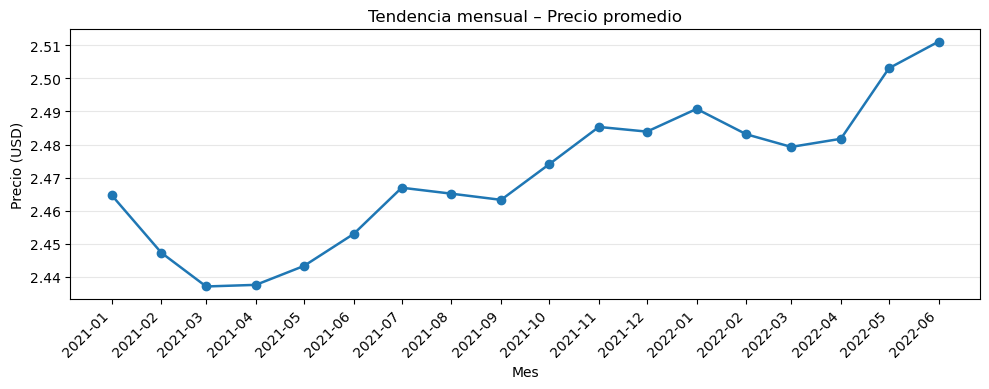

In [8]:
# === Gráficos EDA  ===
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from pathlib import Path

# usa el dataset limpio o  df
base_df = clean if 'clean' in globals() else df
Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)

# -------------------------------------------------
# 1) Tendencia mensual – Precio promedio 
# -------------------------------------------------
trend = (base_df.groupby('fecha_mes', dropna=True)['precio']
         .mean().reset_index().sort_values('fecha_mes'))

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(trend['fecha_mes'], trend['precio'], marker='o', linewidth=1.8)
ax.set_title("Tendencia mensual – Precio promedio")
ax.set_xlabel("Mes"); ax.set_ylabel("Precio (USD)")

# ticks mensuales y formato AAAA-MM
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
fig.autofmt_xdate(rotation=45, ha="right")

ax.grid(True, axis='y', alpha=0.3)
fig.tight_layout()
plt.savefig(f"{SAVE_DIR}/trend_mensual.png", dpi=144, bbox_inches="tight")
plt.show()



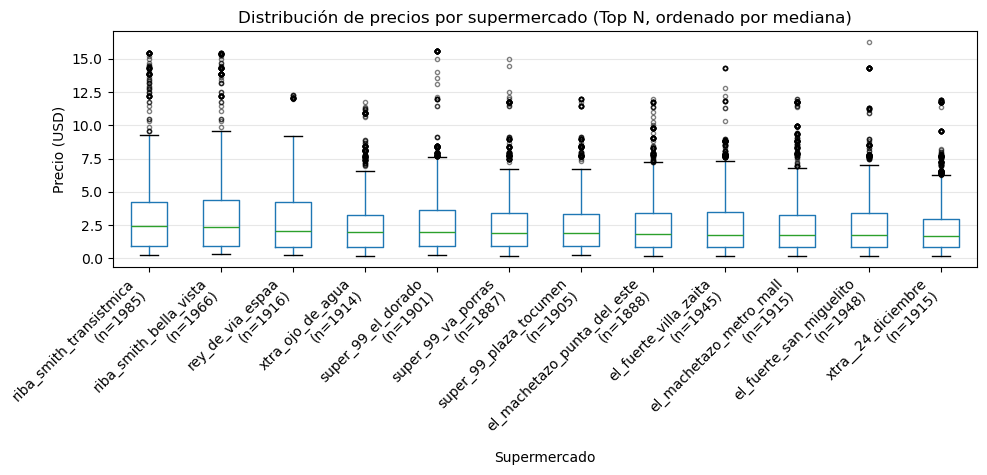

In [9]:
import matplotlib.pyplot as plt

N = 12
top_sup = clean["supermercado"].value_counts().head(N).index
sub = clean[clean["supermercado"].isin(top_sup)].copy()

# ordenar por mediana descendente
order = (sub.groupby("supermercado")["precio"]
           .median().sort_values(ascending=False).index)
sub["supermercado"] = pd.Categorical(sub["supermercado"], categories=order, ordered=True)

fig, ax = plt.subplots(figsize=(10,5))
sub.boxplot(
    column="precio", by="supermercado", ax=ax, grid=False, showfliers=True,
    flierprops=dict(marker="o", markersize=3, alpha=0.5)
)
ax.figure.suptitle("")
ax.set_title("Distribución de precios por supermercado (Top N, ordenado por mediana)")
ax.set_xlabel("Supermercado"); ax.set_ylabel("Precio (USD)")
ax.grid(axis="y", alpha=0.3)

# añade conteos (n) en cada etiqueta
counts = sub["supermercado"].value_counts()
ax.set_xticklabels([f"{s}\n(n={counts[s]})" for s in order], rotation=45, ha="right")

fig.tight_layout()
plt.show()


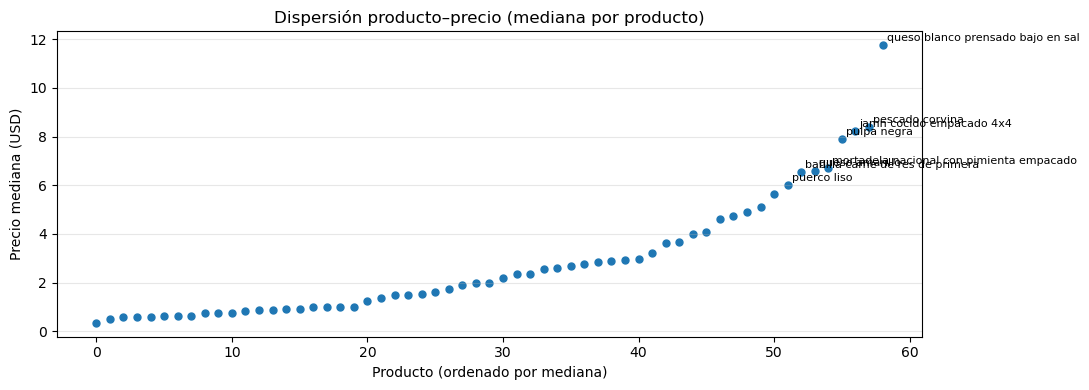

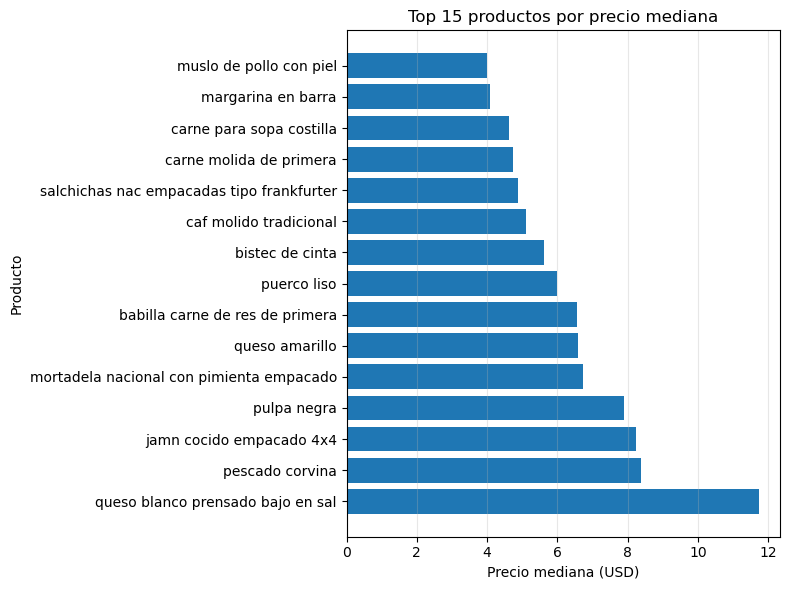

In [10]:
# Ordenado por mediana + anotaciones de los más caros
agg = (clean.groupby("producto")["precio"]
       .median().reset_index().sort_values("precio").reset_index(drop=True))

fig, ax = plt.subplots(figsize=(11,4))
ax.scatter(agg.index, agg["precio"], s=25)
ax.set_title("Dispersión producto–precio (mediana por producto)")
ax.set_xlabel("Producto (ordenado por mediana)"); ax.set_ylabel("Precio mediana (USD)")
ax.grid(axis="y", alpha=0.3)

# anota los 8 más caros
topk = agg.tail(8)
for i, r in topk.iterrows():
    ax.annotate(r["producto"], (i, r["precio"]),
                xytext=(3,3), textcoords="offset points", fontsize=8)
plt.tight_layout(); plt.show()

# Top 15 en barras horizontales
top15 = agg.tail(15)
fig, ax = plt.subplots(figsize=(8,6))
ax.barh(top15["producto"], top15["precio"])
ax.set_title("Top 15 productos por precio mediana")
ax.set_xlabel("Precio mediana (USD)"); ax.set_ylabel("Producto")
ax.grid(axis="x", alpha=0.3)
ax.invert_yaxis()  # el más caro arriba
plt.tight_layout(); plt.show()


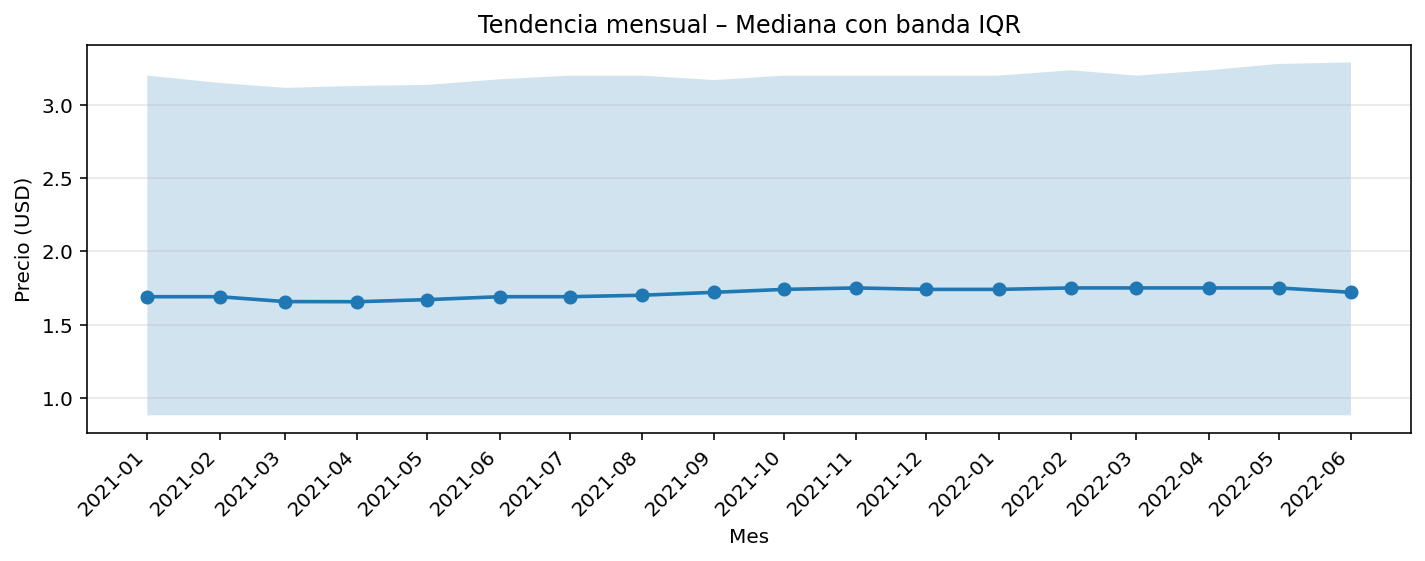

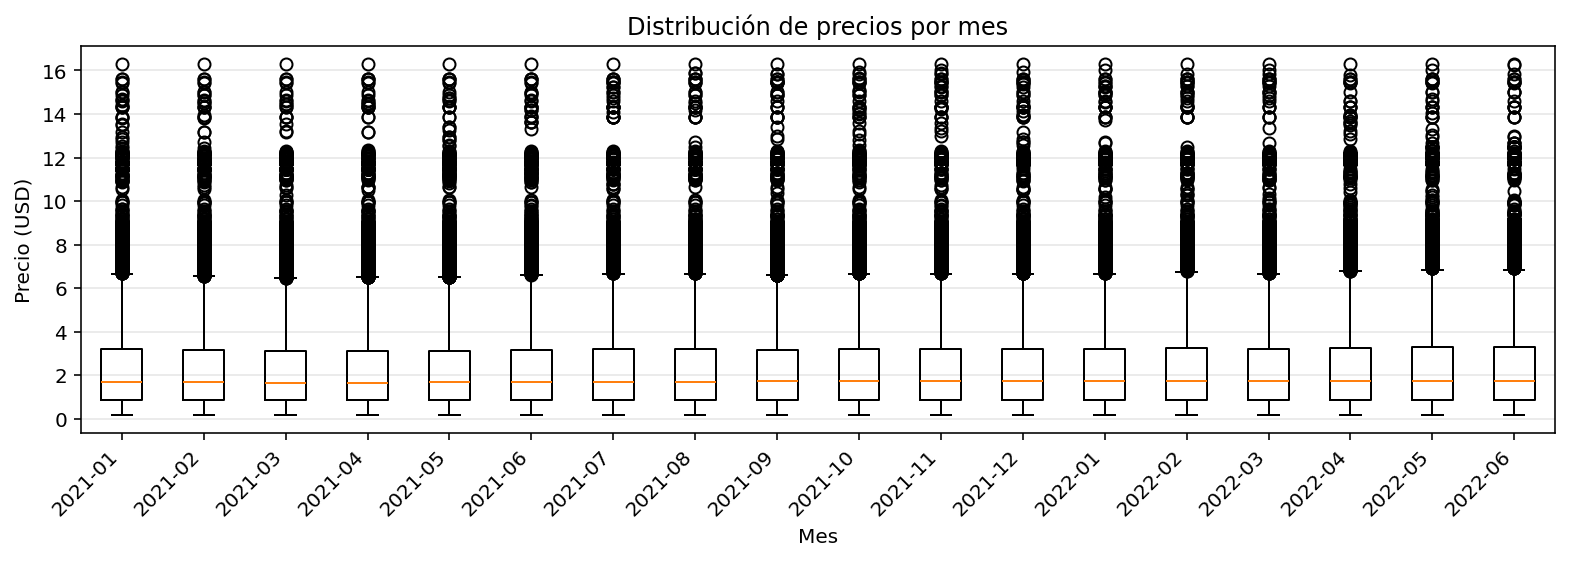

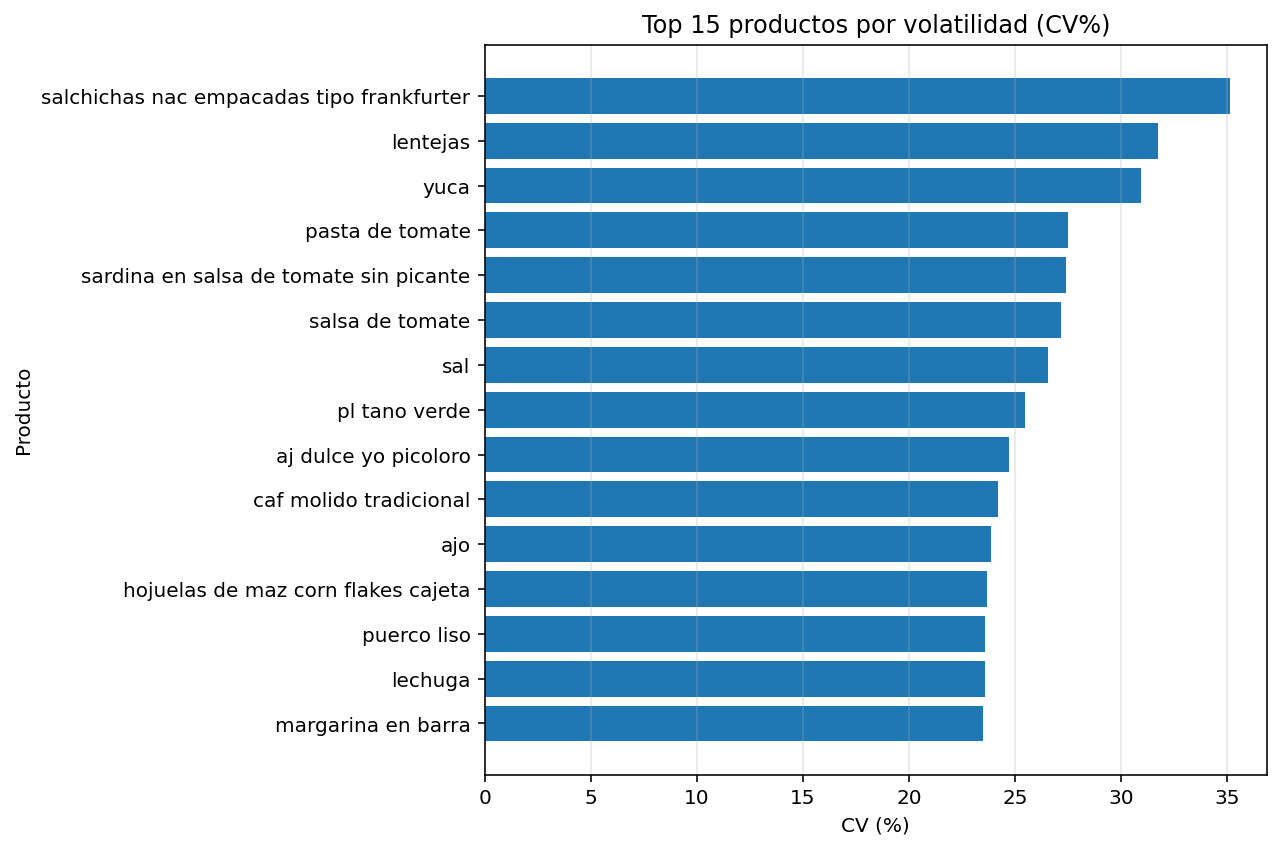

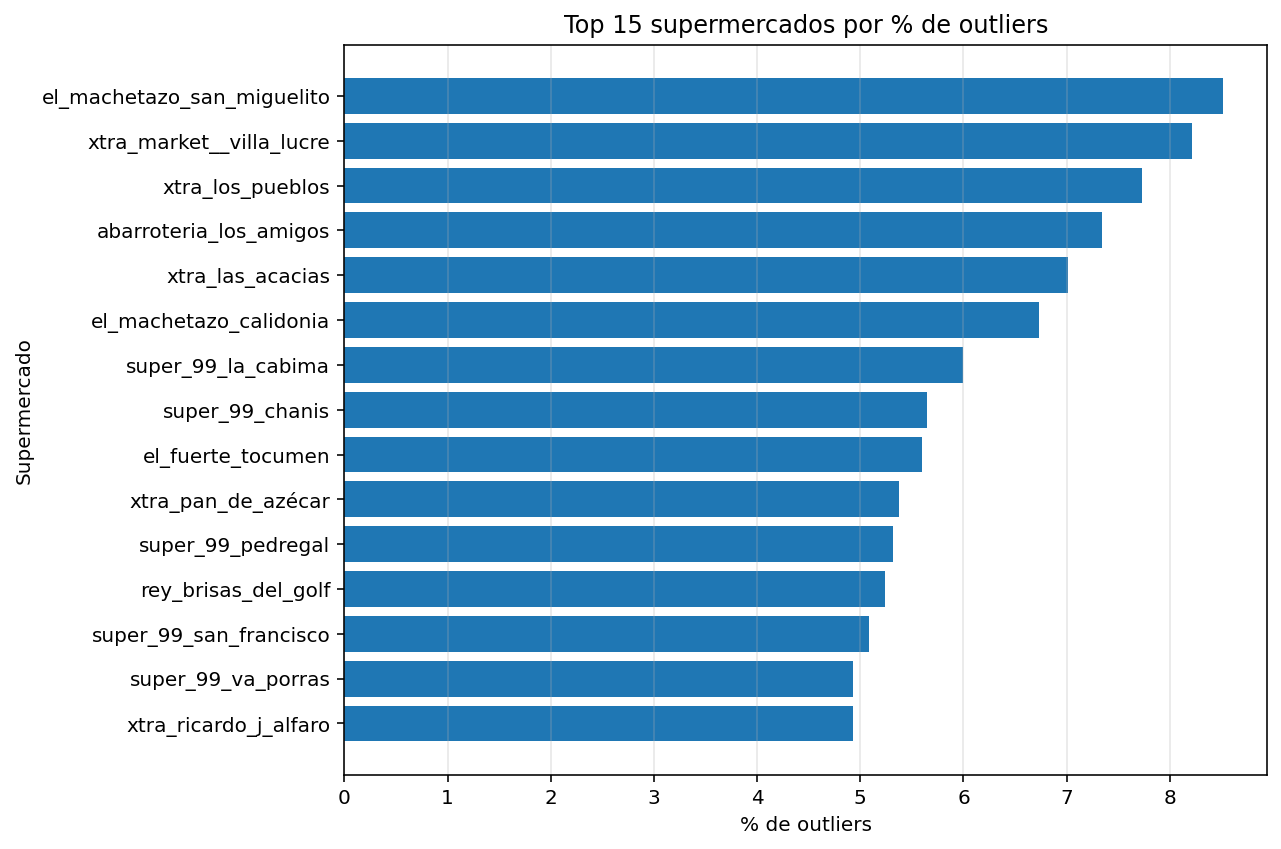

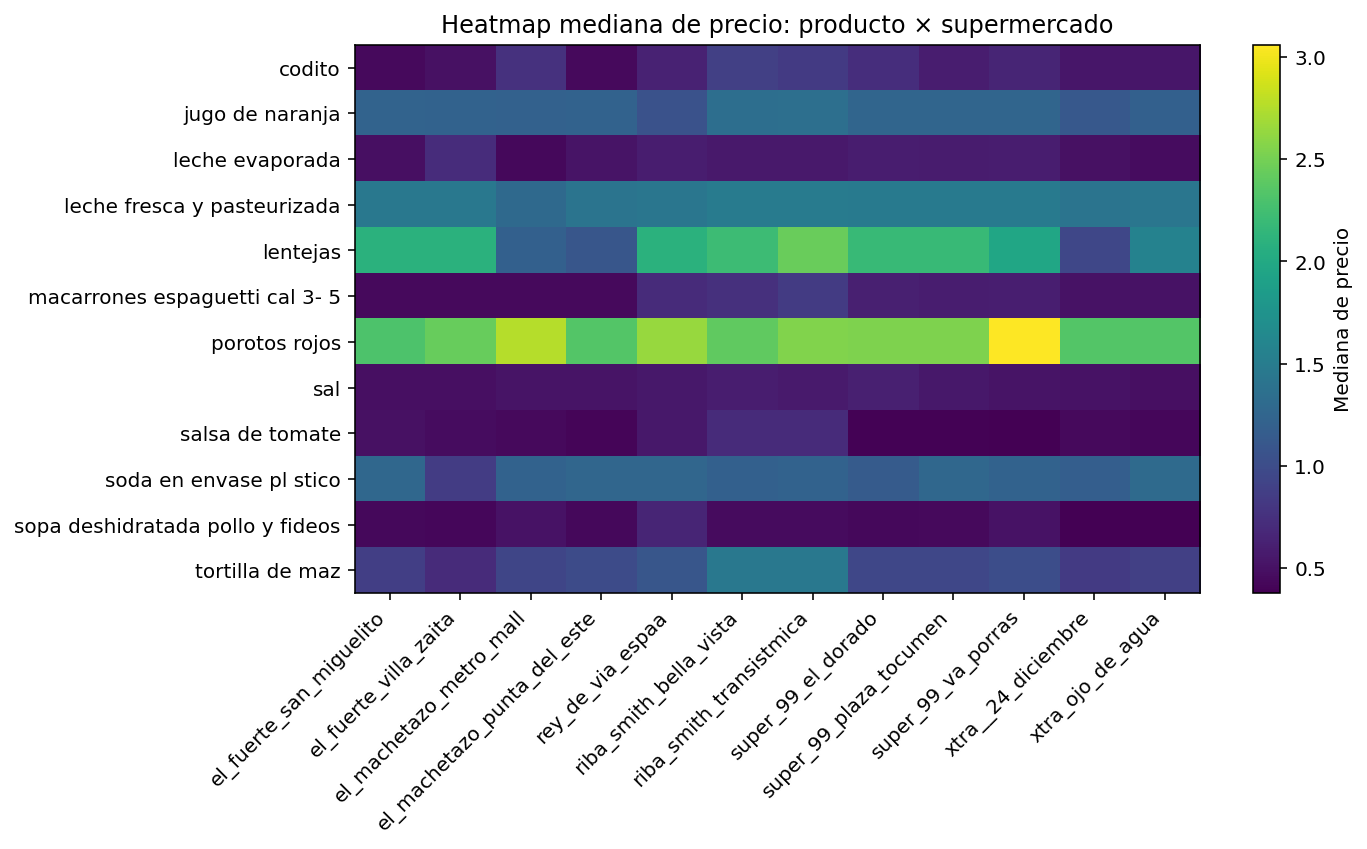

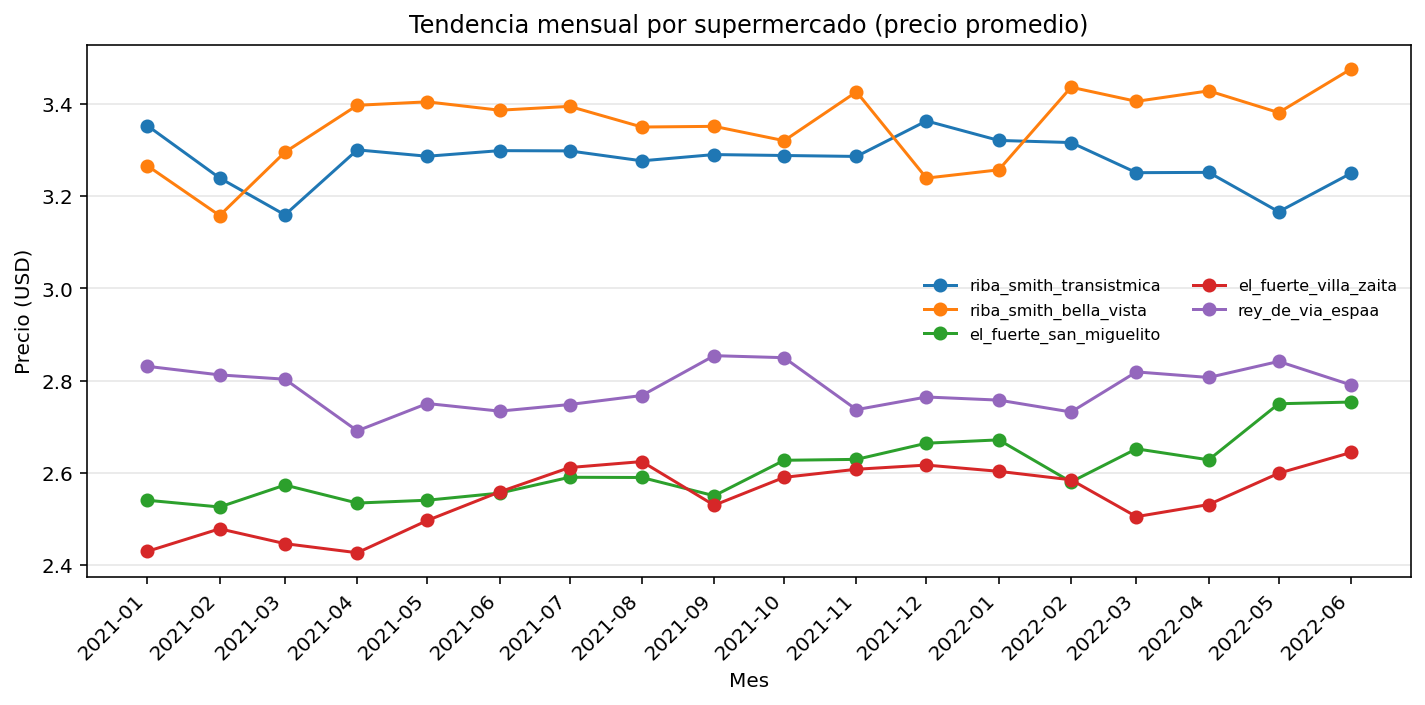

In [11]:
# === GRÁFICAS DE EDA ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path

# usa el dataset limpio si está disponible
base_df = clean if 'clean' in globals() else df.dropna(subset=['precio','fecha_mes']).copy()
Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)
plt.rcParams.update({"figure.dpi": 144})

# -------------------------------
# 1) Tendencia mensual (mediana) 
#    + banda IQR (Q1–Q3)
# -------------------------------
m = (base_df.groupby('fecha_mes')['precio']
     .agg(mediana='median', q1=lambda s: s.quantile(0.25), q3=lambda s: s.quantile(0.75))
     .reset_index().sort_values('fecha_mes'))

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(m['fecha_mes'], m['mediana'], marker='o', linewidth=1.8)
ax.fill_between(m['fecha_mes'], m['q1'], m['q3'], alpha=0.2)
ax.set_title("Tendencia mensual – Mediana con banda IQR")
ax.set_xlabel("Mes"); ax.set_ylabel("Precio (USD)")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
fig.autofmt_xdate(rotation=45, ha="right")
ax.grid(axis='y', alpha=0.3)
fig.tight_layout()
plt.savefig(f"{SAVE_DIR}/trend_mensual_mediana_IQR.png", bbox_inches="tight")
plt.show()

# ---------------------------------------------------------
# 2) Boxplot por mes (distribución mensual de los precios)
# ---------------------------------------------------------
g = base_df.dropna(subset=['fecha_mes','precio']).copy()
months = g['fecha_mes'].sort_values().unique()
data = [g.loc[g['fecha_mes']==mx, 'precio'].values for mx in months]

fig, ax = plt.subplots(figsize=(11,4))
ax.boxplot(data, positions=range(len(months)), showfliers=True)
ax.set_title("Distribución de precios por mes")
ax.set_xlabel("Mes"); ax.set_ylabel("Precio (USD)")
ax.set_xticks(range(len(months)))
ax.set_xticklabels([pd.to_datetime(x).strftime("%Y-%m") for x in months], rotation=45, ha="right")
ax.grid(axis='y', alpha=0.3)
fig.tight_layout()
plt.savefig(f"{SAVE_DIR}/boxplot_por_mes.png", bbox_inches="tight")
plt.show()

# -----------------------------------------------------------------
# 3) Top productos por volatilidad (CV%) 
# -----------------------------------------------------------------
stats_prod = (base_df.groupby('producto')['precio']
              .agg(media='mean', std='std', n='count').reset_index())
stats_prod['cv_%'] = (stats_prod['std'] / stats_prod['media'] * 100)
topk = (stats_prod[stats_prod['n']>=5]  # exige al menos 5 observaciones
        .sort_values('cv_%', ascending=False).head(15))

fig, ax = plt.subplots(figsize=(9,6))
ax.barh(topk['producto'], topk['cv_%'])
ax.set_title("Top 15 productos por volatilidad (CV%)")
ax.set_xlabel("CV (%)"); ax.set_ylabel("Producto")
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()
fig.tight_layout()
plt.savefig(f"{SAVE_DIR}/top_productos_volatilidad_cv.png", bbox_inches="tight")
plt.show()

# -----------------------------------------------------------------------
# 4) Tasa de outliers por supermercado 

# -----------------------------------------------------------------------
def quick_outliers(df_in, k=3.0):
    q1 = df_in['precio'].quantile(0.25)
    q3 = df_in['precio'].quantile(0.75)
    iqr = q3 - q1
    lo, hi = (q1 - k*iqr, q3 + k*iqr) if iqr>0 else (df_in['precio'].min()-1e-9, df_in['precio'].max()+1e-9)
    return df_in[(df_in['precio']<lo) | (df_in['precio']>hi)]

outs = outliers if 'outliers' in globals() else quick_outliers(base_df)
rate = (outs.groupby('supermercado').size()
        .div(base_df.groupby('supermercado').size())
        .mul(100).rename('pct_outliers').reset_index())
rate = rate.dropna().sort_values('pct_outliers', ascending=False).head(15)

fig, ax = plt.subplots(figsize=(9,6))
ax.barh(rate['supermercado'], rate['pct_outliers'])
ax.set_title("Top 15 supermercados por % de outliers")
ax.set_xlabel("% de outliers"); ax.set_ylabel("Supermercado")
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()
fig.tight_layout()
plt.savefig(f"{SAVE_DIR}/outliers_rate_por_supermercado.png", bbox_inches="tight")
plt.show()

# --------------------------------------------------------------------------------
# 5) Heatmap producto × supermercado (precio mediana) — Top N×M para legibilidad
# --------------------------------------------------------------------------------
N_PROD, M_SUP = 12, 12
top_prods = base_df['producto'].value_counts().head(N_PROD).index
top_sups  = base_df['supermercado'].value_counts().head(M_SUP).index
hm = (base_df[base_df['producto'].isin(top_prods) & base_df['supermercado'].isin(top_sups)]
      .pivot_table(index='producto', columns='supermercado', values='precio', aggfunc='median'))

fig, ax = plt.subplots(figsize=(10,6))
im = ax.imshow(hm.values, aspect='auto')
ax.set_title("Heatmap mediana de precio: producto × supermercado")
ax.set_yticks(range(len(hm.index)));  ax.set_yticklabels(hm.index)
ax.set_xticks(range(len(hm.columns))); ax.set_xticklabels(hm.columns, rotation=45, ha='right')
fig.colorbar(im, ax=ax, label='Mediana de precio')
fig.tight_layout()
plt.savefig(f"{SAVE_DIR}/heatmap_producto_super_mediana.png", bbox_inches="tight")
plt.show()

# ------------------------------------------------------------------------------------
# 6) Tendencias por supermercado (Top 6) — líneas en una sola figura
# ------------------------------------------------------------------------------------
top6 = base_df['supermercado'].value_counts().head(5).index
tmp = (base_df[base_df['supermercado'].isin(top6)]
       .groupby(['fecha_mes','supermercado'])['precio'].mean().reset_index())
fig, ax = plt.subplots(figsize=(10,5))
for s in top6:
    t = tmp[tmp['supermercado']==s].sort_values('fecha_mes')
    ax.plot(t['fecha_mes'], t['precio'], marker='o', label=s)
ax.set_title("Tendencia mensual por supermercado (precio promedio)")
ax.set_xlabel("Mes"); ax.set_ylabel("Precio (USD)")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
fig.autofmt_xdate(rotation=45, ha="right")
ax.legend(ncol=2, fontsize=8, frameon=False)
ax.grid(axis='y', alpha=0.3)
fig.tight_layout()
plt.savefig(f"{SAVE_DIR}/tendencias_por_supermercado.png", bbox_inches="tight")
plt.show()


In [12]:
# Guardar limpio definitivo (para modelado o siguientes notebooks)
clean_final = clean.copy()  # requiere que ya hayas corrido la celda de outliers (clean)
clean_final.to_csv(f"{SAVE_DIR}/clean_final.csv", index=False)
print(f"clean_final guardado en {SAVE_DIR}/clean_final.csv con {len(clean_final)} filas.")

# Texto breve para tu informe (puedes copiar/pegar)
print("""
**Parte 8 – EDA y Limpieza (Resumen)**
- Unificación/validación: se mapeó a esquema canónico y se validaron tipos; se documentaron duplicados y precios fuera de rango.
- Outliers (IQR): se aplicó por (producto–presentación–supermercado) con k=3.0; si el grupo fue pequeño, se usaron límites por producto y, en última instancia, globales.
- Estadísticos: se reportan media, mediana, std, min, max y CV% por producto y por supermercado.
- Visualizaciones: tendencia mensual; cajas por supermercado; dispersión producto–precio (mediana).
""")


clean_final guardado en outputs/eda/clean_final.csv con 179366 filas.

**Parte 8 – EDA y Limpieza (Resumen)**
- Unificación/validación: se mapeó a esquema canónico y se validaron tipos; se documentaron duplicados y precios fuera de rango.
- Outliers (IQR): se aplicó por (producto–presentación–supermercado) con k=3.0; si el grupo fue pequeño, se usaron límites por producto y, en última instancia, globales.
- Estadísticos: se reportan media, mediana, std, min, max y CV% por producto y por supermercado.
- Visualizaciones: tendencia mensual; cajas por supermercado; dispersión producto–precio (mediana).



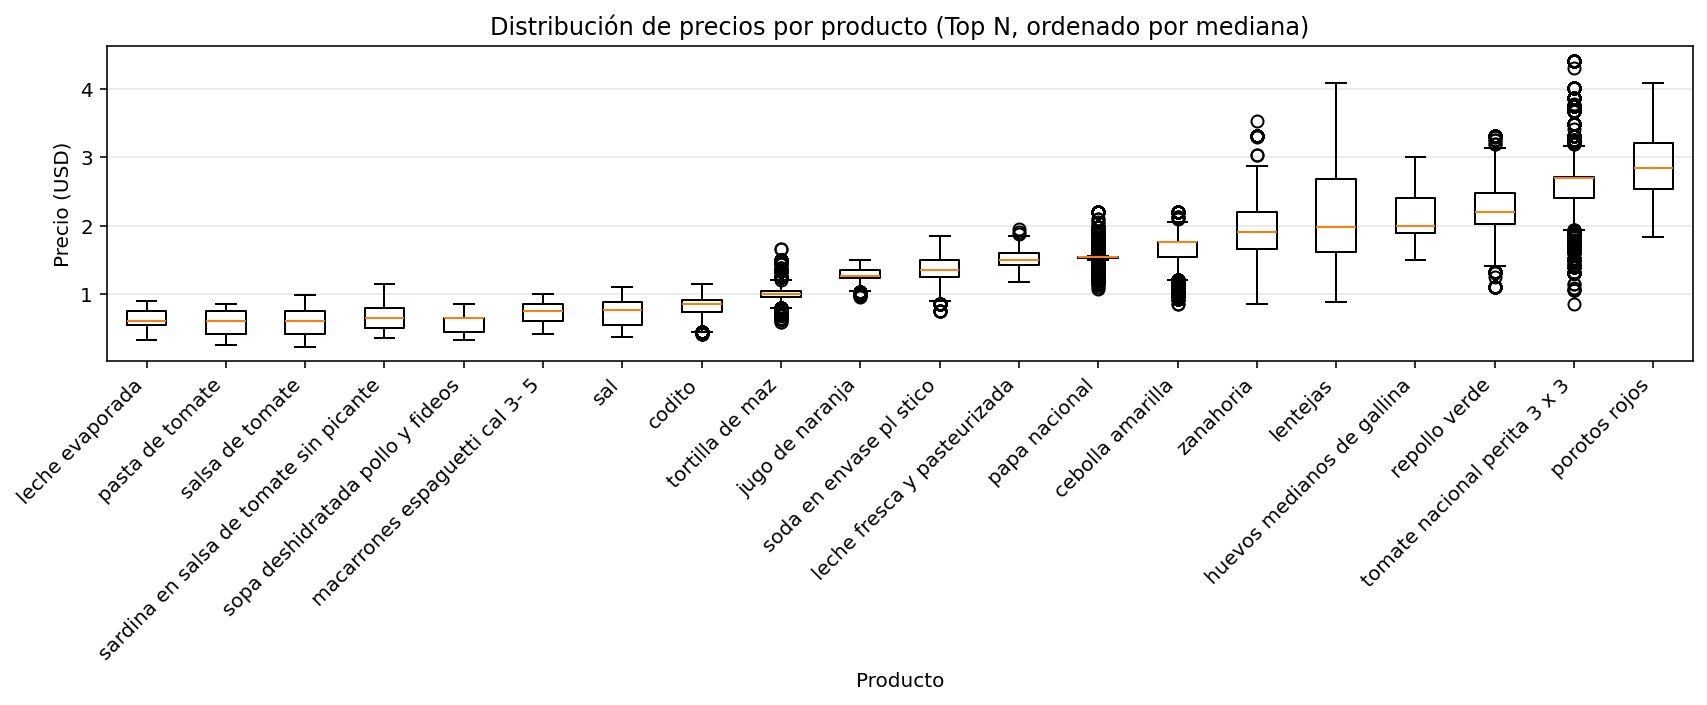

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
 
# Usa el dataset limpio si existe; si no, usa df con mínimos filtros
base_df = clean if 'clean' in globals() else df.dropna(subset=['precio','producto']).copy()
SAVE_DIR = globals().get("SAVE_DIR", "outputs/eda")
Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)
 
# --- Top N productos por número de observaciones ---
N = 20  # ajusta si quieres más/menos productos
top_prods = (base_df['producto']
             .value_counts()
             .head(N)
             .index)
 
sub = base_df[base_df['producto'].isin(top_prods)].copy()
 
# --- Orden por mediana de precio (de menor a mayor) ---
order = (sub.groupby('producto')['precio']
           .median()
           .sort_values()
           .index)
 
# --- Datos para el boxplot en el orden elegido ---
data = [sub.loc[sub['producto'] == p, 'precio'].values for p in order]
 
# --- Figura ---
fig_w = max(10, N * 0.6)  # ancho dinámico según N
fig, ax = plt.subplots(figsize=(fig_w, 5))
ax.boxplot(data, positions=range(len(order)), showfliers=True)
 
ax.set_title("Distribución de precios por producto (Top N, ordenado por mediana)")
ax.set_xlabel("Producto")
ax.set_ylabel("Precio (USD)")
ax.set_xticks(range(len(order)))
ax.set_xticklabels(order, rotation=45, ha="right")
ax.grid(axis="y", alpha=0.3)
 
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/boxplot_por_producto.png", dpi=144, bbox_inches="tight")
plt.show()